<a href="https://colab.research.google.com/github/rahatkader/text-classification-comparing-different-models/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Library File Import & Dataset Loading**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/SCL/Assignment 2/Dataset.csv")
df.head(5)

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


# **Dataset Exploration & Visualisation**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [ ]:
df.describe()

,Sentiment
count,5791.000000
mean,0.272664
std,0.962192
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000




---


**Records in each class**

In [ ]:
def plot_stats(df, column, ax, color, angle):
  count_classes = df[column].value_counts()
  ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
  ax.set_title(column.upper(), fontsize=18)
  for tick in ax.get_xticklabels():
    tick.set_rotation(angle)

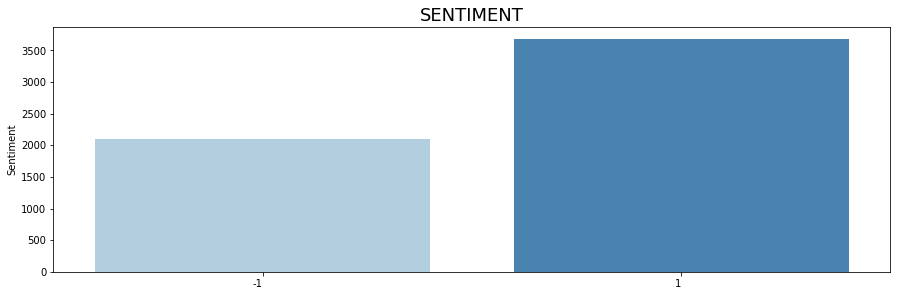

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(df, "Sentiment", axes, "Blues", 0)
plt.show()



---


**The number of characters in each class**

In [ ]:
def number_of_characters(df, label, ax, color):
    tweet_len = df[df['Sentiment']==label]['Text'].str.len()
    ax.hist(tweet_len, color=color)
    ax.set_title(label, fontsize=18)

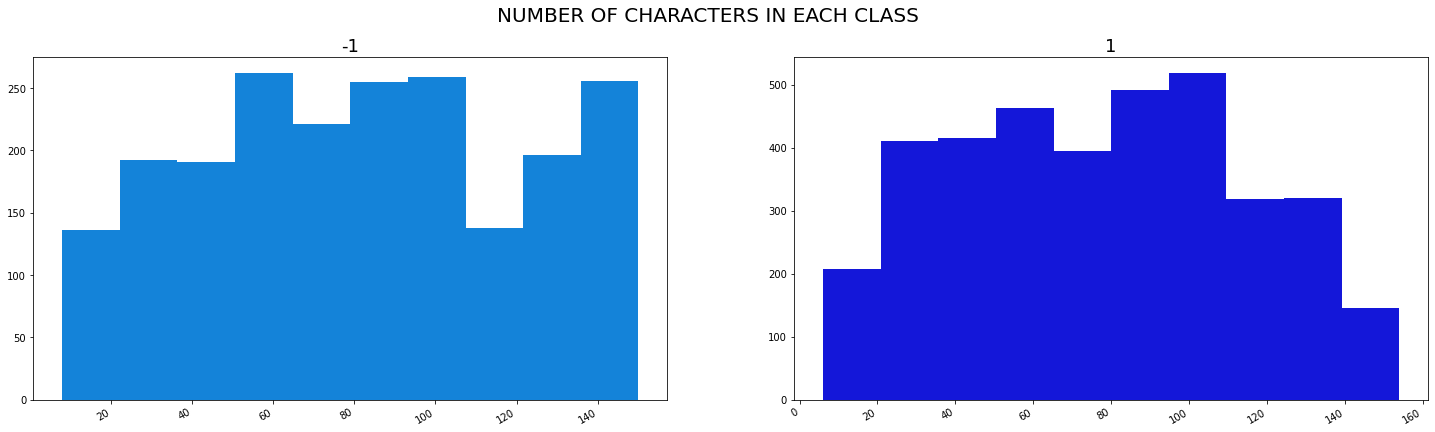

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,7))
fig.autofmt_xdate()
fig.suptitle('NUMBER OF CHARACTERS IN EACH CLASS', fontsize=20)
number_of_characters(df, -1, axes[0], '#1483d9')
number_of_characters(df, 1, axes[1], '#1417d9')
plt.show()



---


**Average word length**

In [ ]:
def avg_word_length(df, label, ax, color):
    word = df[df['Sentiment']==label]['Text'].str.split().apply(lambda x : [len(i) for i in x])
    sns.distplot(word.map(lambda x: np.mean(x)), ax=ax, color=color)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


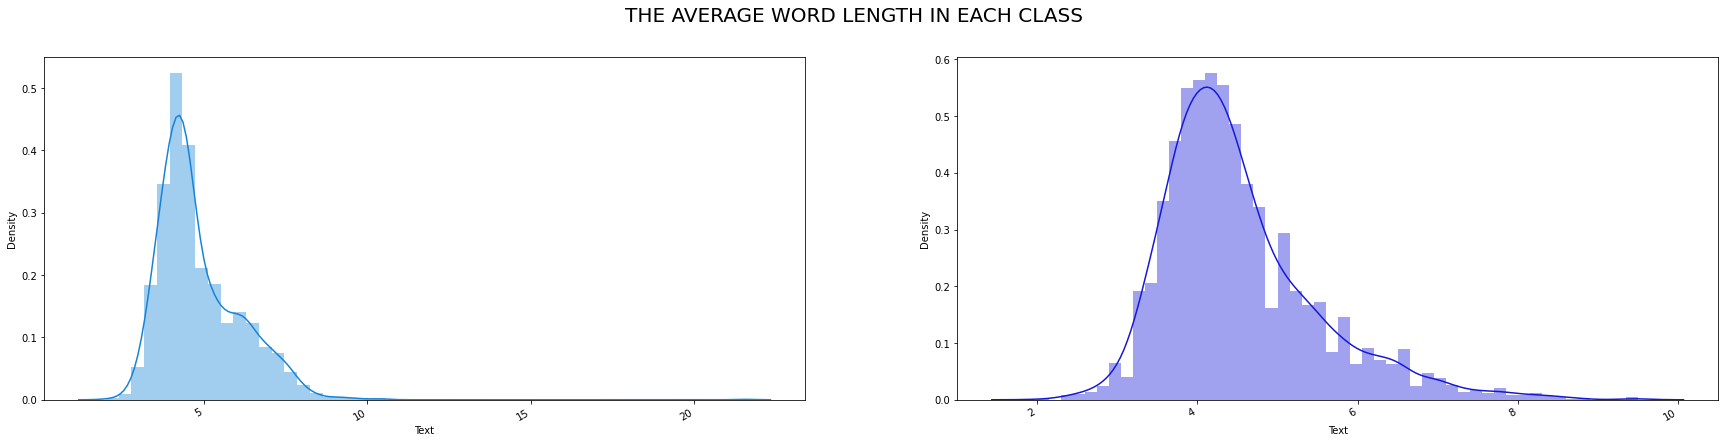

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,7))
fig.autofmt_xdate()
fig.suptitle('THE AVERAGE WORD LENGTH IN EACH CLASS', fontsize=20)
avg_word_length(df, -1, axes[0], '#1483d9')
avg_word_length(df, 1, axes[1], '#1417d9')
plt.show()

# **Pre-Processing Steps**



---


**Stop word removal**

In [ ]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Text"] = df["Text"].apply(lambda text: remove_stopwords(text))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Text,Sentiment
0,Kickers watchlist XIDE TIT SOQ PNK CPW BPZ AJ ...,1
1,user: AAP MOVIE. 55% return FEA/GEED indicator...,1
2,user I'd afraid short AMZN - looking like near...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1




---


**Stemming**

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["Text"] = df["Text"].apply(lambda text: stem_words(text))
df.head()

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz AJ t...,1
1,user: aap movie. 55% return fea/ge indic 15 tr...,1
2,user i'd afraid short amzn - look like near-mo...,1
3,mnta over 12.00,1
4,OI over 21.37,1


In [ ]:
df_train = df.head(5000)
df_test = df.tail(790)

# **Models**



---

**Neural Network**

In [ ]:
class NNClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super().__init__()

        self.linear_1 = nn.Linear(vocab_size, hidden1)
        self.linear_2 = nn.Linear(hidden1, hidden1)
        self.linear_3 = nn.Linear(hidden1, hidden1)
        self.linear_4 = nn.Linear(hidden1, hidden2)
        self.linear_out = nn.Linear(hidden2, 1)

        self.relu = nn.ReLU()
        
        
    def forward(self, inputs):

        out = self.relu(self.linear_1(inputs.squeeze(1).float()))
        
        out = self.relu(self.linear_2(out))

        out = self.relu(self.linear_3(out))

        out = self.relu(self.linear_4(out))

        logits  = self.linear_out(out)
        
        return logits



---

**Convulution Neural Network(CNN)**

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CNNClassifier, self).__init__()
        self.cnn_layer_1 = nn.Conv2d(in_channels=1, out_channels=256,kernel_size=3, stride=1)
        self.cnn_layer_2 = nn.Conv2d(in_channels=256, out_channels=32,kernel_size=3, stride=1)
        
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(2)
        
        self.linear_layer_1 = nn.Linear(32*148*148, 512)  
        self.linear_layer_2 = nn.Linear(512, 128) 
        self.linear_layer_3 = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(.2)
        # self.flatten = nn.Flatten()
        
    def forward(self, x):

        x = self.cnn_layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        print(x.shape)
        
        x = self.cnn_layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        print(x.shape)
        
        x = self.flatten(x)
        print(x.shape)
        
        x = self.linear_layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.linear_layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        
        logits = self.linear_layer_3(x)
        #logits = self.sigmoid(x)
        return logits

# **BoW and Neural Network**

In [ ]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(binary=True)
        self.sequences = self.vectorizer.fit_transform(data.Text.tolist())
        self.labels = data.Sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]


dataset = Sequences(df_train)
train_loader = DataLoader(dataset, batch_size=50)

In [ ]:
len(dataset.token2idx)

7009

In [ ]:
model = NNClassifier(len(dataset.token2idx), 128, 64)
model

NNClassifier(
  (linear_1): Linear(in_features=7009, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=128, bias=True)
  (linear_4): Linear(in_features=128, out_features=64, bias=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []

for epoch in range(100):
    losses = []
    total = 0
    for inputs, target in train_loader:
        model.zero_grad()

        output = model(inputs)
        loss = criterion(output.squeeze(), target.float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)
        
    print(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')

Epoch #1	Train Loss: 0.222
Epoch #2	Train Loss: -359.587
Epoch #3	Train Loss: -14493.107
Epoch #4	Train Loss: -152088.835
Epoch #5	Train Loss: -789324.794
Epoch #6	Train Loss: -2736006.153
Epoch #7	Train Loss: -7366694.479
Epoch #8	Train Loss: -16656714.560
Epoch #9	Train Loss: -33277896.235
Epoch #10	Train Loss: -60173334.950
Epoch #11	Train Loss: -101137027.600
Epoch #12	Train Loss: -160334635.280
Epoch #13	Train Loss: -242983770.920
Epoch #14	Train Loss: -354540964.080
Epoch #15	Train Loss: -501243914.240
Epoch #16	Train Loss: -689735024.480
Epoch #17	Train Loss: -927741027.680
Epoch #18	Train Loss: -1224299160.000
Epoch #19	Train Loss: -1586564713.920
Epoch #20	Train Loss: -2022140891.840
Epoch #21	Train Loss: -2543329585.280
Epoch #22	Train Loss: -3157896351.360
Epoch #23	Train Loss: -3874805866.240
Epoch #24	Train Loss: -4704685085.440
Epoch #25	Train Loss: -5655621918.720
Epoch #26	Train Loss: -6735741181.440
Epoch #27	Train Loss: -7957533397.760
Epoch #28	Train Loss: -933296641

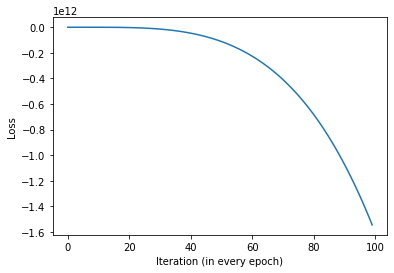

In [ ]:
plt.plot(train_losses)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every epoch)')
plt.show()

In [ ]:
def predict_sentiment(text):
  test_vector = torch.LongTensor(dataset.vectorizer.transform([text]).toarray())
  
  output = model(test_vector)
  
  prediction = torch.sigmoid(output).item()
  
  if prediction>0.5:
    return 1
  else:
    return -1

In [ ]:
pred_labels = []

sentences = list(df_test['Text'])
labels = df_test['Sentiment']

for sentence in sentences:
  pred_labels.append(predict_sentiment(sentence))

accuracy = accuracy_score(labels, pred_labels)
print('Accuracy: %f' % accuracy)

matrix = confusion_matrix(labels, pred_labels)
print('Confusion Matrix: \n', matrix)

precision =  precision_score(labels, pred_labels)
print('Precision: %f' % precision)

recall = recall_score(labels, pred_labels)
print('Recall: %f' % recall)

f1_score = 2 * (precision * recall) / (precision + recall)
print('f1 score: %f' % f1_score)

Accuracy: 0.588608
Confusion Matrix: 
 [[426  31]
 [294  39]]
Precision: 0.557143
Recall: 0.117117
f1 score: 0.193548


# **TF-IDF and Neural Network**

In [ ]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = TfidfVectorizer()
        self.sequences = self.vectorizer.fit_transform(data.Text.tolist())
        self.labels = data.Sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]


dataset2 = Sequences(df_train)
train_loader2 = DataLoader(dataset2, batch_size=50)

In [ ]:
model2 = NNClassifier(len(dataset2.token2idx), 128, 64)
model2

NNClassifier(
  (linear_1): Linear(in_features=7009, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=128, bias=True)
  (linear_3): Linear(in_features=128, out_features=128, bias=True)
  (linear_4): Linear(in_features=128, out_features=64, bias=True)
  (linear_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
criterion2 = nn.BCEWithLogitsLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
train_losses2 = []

for epoch in range(100):
    losses = []
    total = 0
    for inputs, target in train_loader2:
        model2.zero_grad()

        output = model2(inputs)
        loss = criterion2(output.squeeze(), target.float())
        loss.backward()
        optimizer2.step()
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses2.append(epoch_loss)
        
    print(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.4f}')

Epoch #1	Train Loss: 0.5304
Epoch #2	Train Loss: -84.6124
Epoch #3	Train Loss: -3956.5350
Epoch #4	Train Loss: -44027.8556
Epoch #5	Train Loss: -237808.3972
Epoch #6	Train Loss: -849038.1690
Epoch #7	Train Loss: -2309901.5794
Epoch #8	Train Loss: -5277669.0663
Epoch #9	Train Loss: -10621583.7812
Epoch #10	Train Loss: -19469195.8275
Epoch #11	Train Loss: -33136625.4250
Epoch #12	Train Loss: -53195134.5700
Epoch #13	Train Loss: -81083414.9900
Epoch #14	Train Loss: -118641858.5800
Epoch #15	Train Loss: -168028809.4400
Epoch #16	Train Loss: -231293257.8400
Epoch #17	Train Loss: -311002160.4400
Epoch #18	Train Loss: -410282400.5600
Epoch #19	Train Loss: -532009177.5200
Epoch #20	Train Loss: -679997491.5200
Epoch #21	Train Loss: -856989108.4800
Epoch #22	Train Loss: -1067301963.3600
Epoch #23	Train Loss: -1313520920.9600
Epoch #24	Train Loss: -1599774790.4000
Epoch #25	Train Loss: -1929291348.1600
Epoch #26	Train Loss: -2306790932.4800
Epoch #27	Train Loss: -2734142003.8400
Epoch #28	Train L

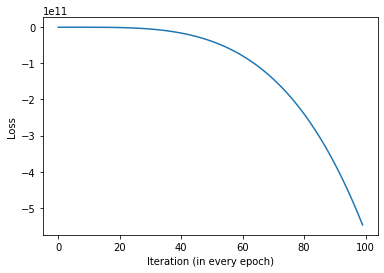

In [ ]:
plt.plot(train_losses2)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every epoch)')
plt.show()

In [ ]:
def predict_sentiment(text):
  test_vector = torch.LongTensor(dataset2.vectorizer.transform([text]).toarray())
  
  output = model2(test_vector)
  
  prediction = torch.sigmoid(output).item()
  
  if prediction>0.5:
    return 1
  else:
    return -1

In [ ]:
pred_labels2 = []

sentences = list(df_test['Text'])
labels = df_test['Sentiment']

for sentence in sentences:
  pred_labels2.append(predict_sentiment(sentence))

accuracy2 = accuracy_score(labels, pred_labels2)
print('Accuracy: %f' % accuracy2)

matrix2 = confusion_matrix(labels, pred_labels2)
print(matrix2)

precision2 =  precision_score(labels, pred_labels2)
print('Precision: %f' % precision2)

recall2 = recall_score(labels, pred_labels2)
print('Recall: %f' % recall2)

f1_score2 = 2 * (precision2 * recall2) / (precision2 + recall2)
print('f1 score: %f' % f1_score2)

Accuracy: 0.578481
[[457   0]
 [333   0]]
Precision: 0.000000
Recall: 0.000000
f1 score: nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


# **One-Hot Embedding and CNN**

In [ ]:
#pd.get_dummies(df).head()
#dataset = pd.get_dummies(df_train)
#train_loader = DataLoader(dataset, batch_size=900)

class Sequences3(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(binary=True)
        self.sequences = self.vectorizer.fit_transform(data.Text.tolist())
        self.labels = data.Sentiment.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]


dataset3 = Sequences3(df_train)
train_loader3 = DataLoader(dataset3, batch_size=50)

In [ ]:
model3 = CNNClassifier(len(dataset3.token2idx))
model3

CNNClassifier(
  (cnn_layer_1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (cnn_layer_2): Conv2d(256, 32, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer_1): Linear(in_features=700928, out_features=512, bias=True)
  (linear_layer_2): Linear(in_features=512, out_features=128, bias=True)
  (linear_layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
criterion3 = nn.BCEWithLogitsLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

In [ ]:
inputs.shape

torch.Size([1, 1, 7009, 50])

In [ ]:
train_losses3 = []

for epoch in range(100):
    losses = []
    total = 0
    for inputs, target in train_loader3:
        inputs = inputs.reshape(1,1,7009,50)
        model3.zero_grad()
        #inputs = inputs.type(torch.LongTensor)
        output = model3(inputs)
        loss = criterion3(output.squeeze(), target.float())
        loss.backward()
        optimizer3.step()
        losses.append(loss.item())
        total += 1
    
    epoch_loss = sum(losses) / total
    train_losses3.append(epoch_loss)
        
    print(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.4f}')